In [1]:
# general imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import random

In [2]:
# filter python warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# prepare MNIST data
import torchvision.datasets as datasets

# train data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_train_images = mnist_trainset.train_data.numpy()[..., np.newaxis]
mnist_train_labels = mnist_trainset.train_labels.numpy()

# get only train images and labels for two classes: 3 and 8
mnist_train_images_3_8 = np.concatenate([mnist_train_images[mnist_train_labels==3], mnist_train_images[mnist_train_labels==8]])
mnist_train_labels_3_8 = np.concatenate([np.repeat(0, np.sum(mnist_train_labels==3)), np.repeat(1, np.sum(mnist_train_labels==8))])

# test data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_test_images = mnist_testset.test_data.numpy()[..., np.newaxis]
mnist_test_labels = mnist_testset.test_labels.numpy()

# get only test images and labels for two classes: 3 and 8
mnist_test_images_3_8 = np.concatenate([mnist_test_images[mnist_test_labels==3], mnist_test_images[mnist_test_labels==8]])
mnist_test_labels_3_8 = np.concatenate([np.repeat(0, np.sum(mnist_test_labels==3)), np.repeat(1, np.sum(mnist_test_labels==8))])

Label: 0


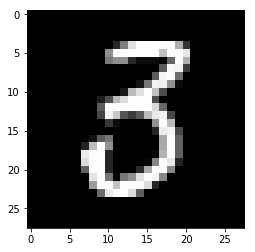

Label: 1


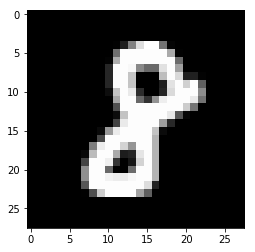

In [4]:
# visualize data and labels
import matplotlib.pyplot as plt
%matplotlib inline

# 3 (label 0)
index = 3000
print("Label:", mnist_train_labels_3_8[index])
plt.imshow(mnist_train_images_3_8[index].reshape(28, 28),cmap='gray')
plt.show()

# 8 (label 1)
index = 8000
print("Label:", mnist_train_labels_3_8[index])
plt.imshow(mnist_train_images_3_8[index].reshape(28, 28),cmap='gray')
plt.show()

In [6]:
print("Naive Random Forest (by flattening the entire image)")
# Train
clf = RandomForestClassifier()
clf.fit(mnist_train_images_3_8.reshape(-1, 28*28*1), mnist_train_labels_3_8)
# Test
mnist_test_preds_3_8 = clf.predict(mnist_test_images_3_8.reshape(-1, 28*28*1))
print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds_3_8)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds_3_8)))

Naive Random Forest (by flattening the entire image)
Test Accuracy: 0.9803427419354839
Validation Confusion Matrix: 
[[994  16]
 [ 23 951]]


In [5]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forests = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        self.kernel_forests = np.zeros((out_dim, out_dim), dtype=np.int).tolist()
        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forests[i][j] = RandomForestClassifier()
                self.kernel_forests[i][j].fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forests:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [10]:
##########################################################
print("DeepConvRF: One ConvRF")
print("Kernel Size: (10,10); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

DeepConvRF: One ConvRF
Kernel Size: (10,10); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (10, 10)
Test Accuracy: 0.9949596774193549
Validation Confusion Matrix: 
[[1001    9]
 [   1  973]]


In [6]:
def run_one_layer_deep_conv_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])
    
    ## Train
    # ConvRF (layer 1)
    conv1 = ConvRF(kernel_size=10, stride=2)
    conv1_map = conv1.convolve_fit(train_images, train_labels)

    # Full RF
    conv1_full_RF = RandomForestClassifier()
    conv1_full_RF.fit(conv1_map.reshape(len(train_images), -1), train_labels)

    ## Test (after ConvRF 1 and Full RF)
    conv1_map_test = conv1.convolve_predict(test_images)
    mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(test_images), -1))

    return accuracy_score(test_labels, mnist_test_preds)

In [7]:
def run_naive_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])

    # Train
    clf = RandomForestClassifier()
    clf.fit(train_images.reshape(-1, 28*28*1), train_labels)
    # Test
    test_preds = clf.predict(test_images.reshape(-1, 28*28*1))
    return accuracy_score(test_labels, test_preds)

In [102]:
# test above functions
print(run_one_layer_deep_conv_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, 0.3, 3, 8))
print(run_naive_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, 0.3, 3, 8))

0.9894153225806451
0.9712701612903226


In [109]:
# accuracy vs num training samples (deep_conv_rf)
deep_conv_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_one_layer_deep_conv_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 3, 8) for _ in range(3)])
    deep_conv_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.9309475806451613
Train Fraction: 0.016681005372000592
Accuracy: 0.9354838709677419
Train Fraction: 0.027825594022071243
Accuracy: 0.9566532258064516
Train Fraction: 0.046415888336127774
Accuracy: 0.9717741935483871
Train Fraction: 0.0774263682681127
Accuracy: 0.9758064516129032
Train Fraction: 0.1291549665014884
Accuracy: 0.9763104838709677
Train Fraction: 0.21544346900318834
Accuracy: 0.9873991935483871
Train Fraction: 0.3593813663804626
Accuracy: 0.9904233870967742
Train Fraction: 0.5994842503189409
Accuracy: 0.9934475806451613
Train Fraction: 1.0
Accuracy: 0.9939516129032258


In [110]:
# accuracy vs num training samples (naive_rf)
naive_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_naive_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 3, 8) for _ in range(3)])
    naive_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.9067540322580645
Train Fraction: 0.016681005372000592
Accuracy: 0.907258064516129
Train Fraction: 0.027825594022071243
Accuracy: 0.9289314516129032
Train Fraction: 0.046415888336127774
Accuracy: 0.9435483870967742
Train Fraction: 0.0774263682681127
Accuracy: 0.9621975806451613
Train Fraction: 0.1291549665014884
Accuracy: 0.9652217741935484
Train Fraction: 0.21544346900318834
Accuracy: 0.967741935483871
Train Fraction: 0.3593813663804626
Accuracy: 0.9773185483870968
Train Fraction: 0.5994842503189409
Accuracy: 0.9813508064516129
Train Fraction: 1.0
Accuracy: 0.9848790322580645


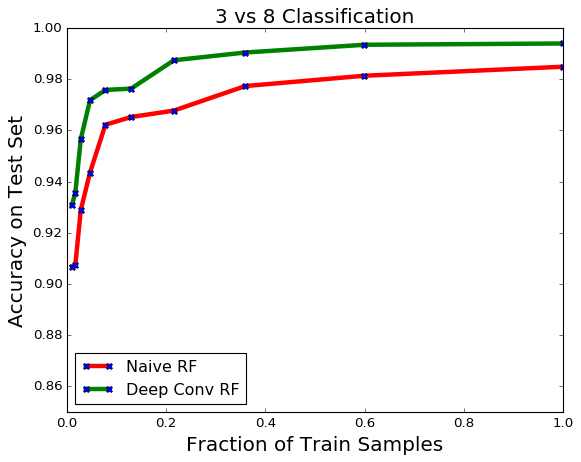

In [120]:
import matplotlib.pyplot as plt; plt.style.use('classic')

plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space, naive_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=6, color='red', linewidth=4, label="Naive RF")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=6, color='green', linewidth=4, label="Deep Conv RF")

ax.set_xlabel('Fraction of Train Samples', fontsize=18)
ax.set_xlim(0, 1)
ax.set_ylabel('Accuracy on Test Set', fontsize=18)
ax.set_ylim(0.85, 1)
ax.set_title("3 vs 8 Classification", fontsize=18)
plt.legend()
plt.show()

In [9]:
# 1 vs 7 Classification

In [10]:
# get only train images and labels for two classes: 1 and 7
mnist_train_images_1_7 = np.concatenate([mnist_train_images[mnist_train_labels==1], mnist_train_images[mnist_train_labels==7]])
mnist_train_labels_1_7 = np.concatenate([np.repeat(0, np.sum(mnist_train_labels==1)), np.repeat(1, np.sum(mnist_train_labels==7))])

# get only test images and labels for two classes: 1 and 7
mnist_test_images_1_7 = np.concatenate([mnist_test_images[mnist_test_labels==1], mnist_test_images[mnist_test_labels==7]])
mnist_test_labels_1_7 = np.concatenate([np.repeat(0, np.sum(mnist_test_labels==1)), np.repeat(1, np.sum(mnist_test_labels==7))])

Label: 0


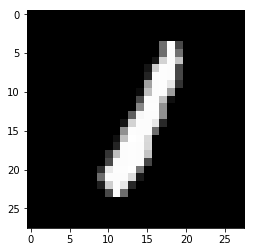

Label: 1


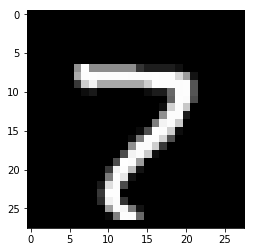

In [11]:
# visualize data and labels
import matplotlib.pyplot as plt
%matplotlib inline

# 1 (label 0)
index = 3000
print("Label:", mnist_train_labels_1_7[index])
plt.imshow(mnist_train_images_1_7[index].reshape(28, 28),cmap='gray')
plt.show()

# 7 (label 1)
index = 8000
print("Label:", mnist_train_labels_1_7[index])
plt.imshow(mnist_train_images_1_7[index].reshape(28, 28),cmap='gray')
plt.show()

In [12]:
print("Naive Random Forest (by flattening the entire image)")
# Train
clf = RandomForestClassifier()
clf.fit(mnist_train_images_1_7.reshape(-1, 28*28*1), mnist_train_labels_1_7)
# Test
mnist_test_preds_1_7 = clf.predict(mnist_test_images_1_7.reshape(-1, 28*28*1))
print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_1_7, mnist_test_preds_1_7)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_1_7, mnist_test_preds_1_7)))

Naive Random Forest (by flattening the entire image)
Test Accuracy: 0.9935275080906149
Validation Confusion Matrix: 
[[1134    1]
 [  13 1015]]


In [13]:
##########################################################
print("DeepConvRF: One ConvRF")
print("Kernel Size: (10,10); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_1_7, mnist_train_labels_1_7)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(mnist_train_images_1_7), -1), mnist_train_labels_1_7)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_1_7)
mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(mnist_test_images_1_7), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_1_7, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_1_7, mnist_test_preds)))

DeepConvRF: One ConvRF
Kernel Size: (10,10); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (10, 10)
Test Accuracy: 0.9953767914932964
Validation Confusion Matrix: 
[[1134    1]
 [   9 1019]]


In [19]:
# accuracy vs num training samples (deep_conv_rf)
deep_conv_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.0003, 0.02, num=10)  # 18 to 1200 samples
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_one_layer_deep_conv_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 1, 7) for _ in range(3)])
    deep_conv_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.00030000000000000014
Accuracy: 0.6888580674988442
Train Fraction: 0.00047838525094581877
Accuracy: 0.8243180767452613
Train Fraction: 0.0007628414944083131
Accuracy: 0.9579288025889967
Train Fraction: 0.0012164403991146804
Accuracy: 0.960702727693019
Train Fraction: 0.0019397571519703604
Accuracy: 0.9435968562182154
Train Fraction: 0.003093170706397624
Accuracy: 0.9648636153490523
Train Fraction: 0.0049324241486609416
Accuracy: 0.9690245030050856
Train Fraction: 0.007865329880427933
Accuracy: 0.9773462783171522
Train Fraction: 0.012542192695400542
Accuracy: 0.9824318076745261
Train Fraction: 0.020000000000000004
Accuracy: 0.9856680536292187


In [20]:
# accuracy vs num training samples (naive_rf)
naive_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.0003, 0.02, num=10) # 18 to 1200 samples
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_naive_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 1, 7) for _ in range(3)])
    naive_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.00030000000000000014
Accuracy: 0.7207582061950994
Train Fraction: 0.00047838525094581877
Accuracy: 0.7124364308830329
Train Fraction: 0.0007628414944083131
Accuracy: 0.9042995839112344
Train Fraction: 0.0012164403991146804
Accuracy: 0.9292649098474342
Train Fraction: 0.0019397571519703604
Accuracy: 0.9560795191863153
Train Fraction: 0.003093170706397624
Accuracy: 0.9546925566343042
Train Fraction: 0.0049324241486609416
Accuracy: 0.9565418400369856
Train Fraction: 0.007865329880427933
Accuracy: 0.9727230698104484
Train Fraction: 0.012542192695400542
Accuracy: 0.9787332408691632
Train Fraction: 0.020000000000000004
Accuracy: 0.9787332408691632


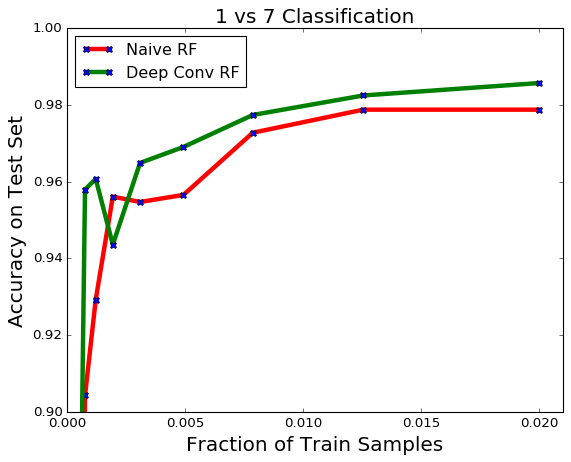

In [22]:
import matplotlib.pyplot as plt; plt.style.use('classic')

plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space, naive_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=6, color='red', linewidth=4, label="Naive RF")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=6, color='green', linewidth=4, label="Deep Conv RF")

ax.set_xlabel('Fraction of Train Samples', fontsize=18)
ax.set_xlim(0, 0.021)
ax.set_ylabel('Accuracy on Test Set', fontsize=18)
ax.set_ylim(0.9, 1)
ax.set_title("1 vs 7 Classification", fontsize=18)
plt.legend()
plt.show()

In [59]:
# 5 vs 6 classification

In [67]:
# accuracy vs num training samples (deep_conv_rf)
deep_conv_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_one_layer_deep_conv_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 5, 6) for _ in range(3)])
    deep_conv_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.9454054054054054
Train Fraction: 0.016681005372000592
Accuracy: 0.9540540540540541
Train Fraction: 0.027825594022071243
Accuracy: 0.9691891891891892
Train Fraction: 0.046415888336127774
Accuracy: 0.9718918918918918
Train Fraction: 0.0774263682681127
Accuracy: 0.9697297297297297
Train Fraction: 0.1291549665014884
Accuracy: 0.9724324324324324
Train Fraction: 0.21544346900318834
Accuracy: 0.9794594594594594
Train Fraction: 0.3593813663804626
Accuracy: 0.9848648648648649
Train Fraction: 0.5994842503189409
Accuracy: 0.9908108108108108
Train Fraction: 1.0
Accuracy: 0.9929729729729729


In [68]:
# accuracy vs num training samples (naive_rf)
naive_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_naive_rf(mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, fraction_of_train_samples, 5, 6) for _ in range(3)])
    naive_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.9275675675675675
Train Fraction: 0.016681005372000592
Accuracy: 0.9448648648648649
Train Fraction: 0.027825594022071243
Accuracy: 0.9497297297297297
Train Fraction: 0.046415888336127774
Accuracy: 0.9643243243243244
Train Fraction: 0.0774263682681127
Accuracy: 0.965945945945946
Train Fraction: 0.1291549665014884
Accuracy: 0.9762162162162162
Train Fraction: 0.21544346900318834
Accuracy: 0.9751351351351352
Train Fraction: 0.3593813663804626
Accuracy: 0.9821621621621621
Train Fraction: 0.5994842503189409
Accuracy: 0.9848648648648649
Train Fraction: 1.0
Accuracy: 0.9864864864864865


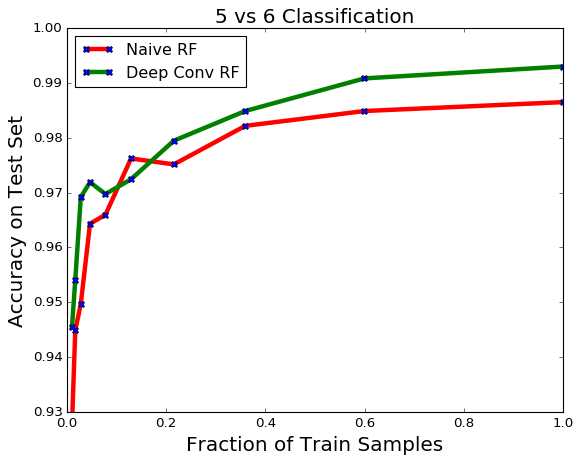

In [69]:
import matplotlib.pyplot as plt; plt.style.use('classic')

plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space, naive_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=6, color='red', linewidth=4, label="Naive RF")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='blue', markersize=6, color='green', linewidth=4, label="Deep Conv RF")

ax.set_xlabel('Fraction of Train Samples', fontsize=18)
ax.set_xlim(0, 1.0)
ax.set_ylabel('Accuracy on Test Set', fontsize=18)
ax.set_ylim(0.93, 1)
ax.set_title("5 vs 6 Classification", fontsize=18)
plt.legend()
plt.show()

In [23]:
# Define a simple CNN
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()        
        #Input channels = 1, output channels = 1
        self.conv1 = torch.nn.Conv2d(1, 1, kernel_size=10, stride=2) ## 32 or 64 filters
        self.fc1 = torch.nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 100)
        x = self.fc1(x)
        return(x)        

In [26]:
import torch.nn as nn
import torch.utils.data as utils

print("Simple CNN Experiment (with one 10x10 filter, stride 2, one relu)")

# set params
num_epochs = 25
learning_rate = 0.001

# prepare data
tensor_x = torch.stack([torch.Tensor(i.reshape(1, 28, 28)) for i in mnist_train_images_3_8]).float() # transform to torch tensors
tensor_y = torch.stack([torch.Tensor([i]) for i in mnist_train_labels_3_8]).long()

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
train_loader = utils.DataLoader(my_dataset, batch_size=64, shuffle=True) # create your dataloader

tensor_x = torch.stack([torch.Tensor(i.reshape(1, 28, 28)) for i in mnist_test_images_3_8]).float() # transform to torch tensors
tensor_y = torch.stack([torch.Tensor([i]) for i in mnist_test_labels_3_8]).long()

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
test_loader = utils.DataLoader(my_dataset, batch_size=64) # create your dataloader

# define model
model = SimpleCNN()

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.view(-1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))

# test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.view(-1) == labels.view(-1)).sum()
    print('Test Accuracy of the SimpleCNN model on the test images: {} %'.format(100 * correct / total))

Simple CNN Experiment (with one 10x10 filter, stride 2, one relu)
Epoch [1/25], Loss: 0.4773
Epoch [2/25], Loss: 0.1700
Epoch [3/25], Loss: 0.0579
Epoch [4/25], Loss: 0.0716
Epoch [5/25], Loss: 0.0238
Epoch [6/25], Loss: 0.0535
Epoch [7/25], Loss: 0.0118
Epoch [8/25], Loss: 0.0084
Epoch [9/25], Loss: 0.0482
Epoch [10/25], Loss: 0.0757
Epoch [11/25], Loss: 0.0076
Epoch [12/25], Loss: 0.0122
Epoch [13/25], Loss: 0.0066
Epoch [14/25], Loss: 0.0694
Epoch [15/25], Loss: 0.0064
Epoch [16/25], Loss: 0.0337
Epoch [17/25], Loss: 0.0051
Epoch [18/25], Loss: 0.0518
Epoch [19/25], Loss: 0.0982
Epoch [20/25], Loss: 0.0587
Epoch [21/25], Loss: 0.1320
Epoch [22/25], Loss: 0.0014
Epoch [23/25], Loss: 0.0047
Epoch [24/25], Loss: 0.0684
Epoch [25/25], Loss: 0.0106
Test Accuracy of the SimpleCNN model on the test images: 98 %


In [ ]:
# try using richard's posterior

In [ ]:
# compare to 1 layer CNN, using only 1 filter, and also using N filters

In [ ]:
# compare multiple layers for both convRF and CNN

In [1]:
# sampling 10 times for DeepConvRF case and plot same curves for DeepConvRF.

In [2]:
# plot loss for all mini bathces and not just epochs in CNN

In [3]:
# fashion MNIST or SVHN or CIFAR or CatsVsDogs

In [4]:
# capsule nets comparison

In [5]:
# CNN with 1 and 32 filters

In [ ]:
# CNN with more layers